In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(autoload_with=engine) #use automap to reflect database

# reflect the tables


In [6]:
# View all of the classes that automap found
Base.classes.keys() #look at table names with keys()

['measurement', 'station']

In [7]:
# Save references to each table
measure = Base.classes.measurement
station = Base.classes.station #putting tables as variables

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
lastdate = session.query(measure.date).order_by(measure.date.desc()).first() 
#query the date, order by descending, first should be last date
lastdate

('2017-08-23',)

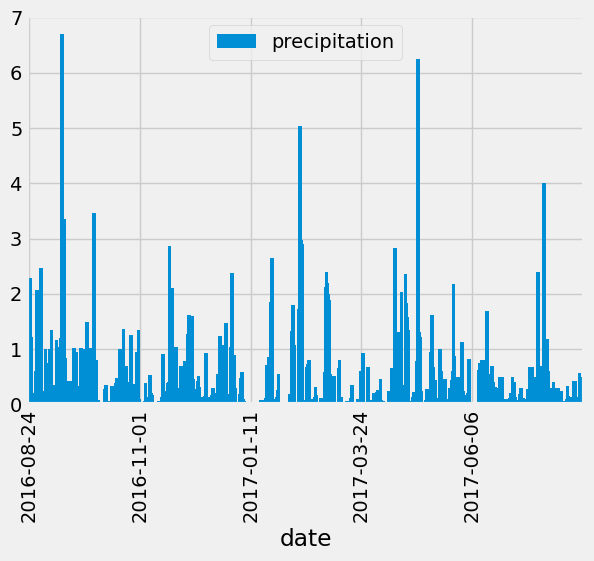

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
lastdatedt = dt.datetime.strptime(lastdate[0],'%Y-%m-%d') #convert date to datetimeobject
# Calculate the date one year from the last date in data set.
yearago = lastdatedt - dt.timedelta(days=365) #use datetime to find 1 year ago (365 days)

# Perform a query to retrieve the data and precipitation scores
prcpdata = session.query(measure.prcp,measure.date).filter(measure.date >=yearago).all() #query data from up to a year ago
prcponly =[]
dateonly=[] #empty lists to convert sqlalchemy output into standard python lists to make things easier
for i in range(len(prcpdata)):
    prcponly.append(prcpdata[i][0])
    dateonly.append(prcpdata[i][1])
# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_df=pd.DataFrame(data = {'precipitation':prcponly, 'date':dateonly}, columns = ['precipitation','date']) #dataframe

# Sort the dataframe by date
prcp_df = prcp_df.sort_values('date') 

# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(kind='bar', x='date',y='precipitation',width=15)
plt.locator_params(axis='x', nbins=5)
plt.show()

In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcount=prcp_df['precipitation'].count()
prmean=prcp_df['precipitation'].mean()
prstd=prcp_df['precipitation'].std()
prmin=prcp_df['precipitation'].min()
prmed=prcp_df['precipitation'].median()
pr25=prcp_df['precipitation'].quantile(q=.25)
pr75=prcp_df['precipitation'].quantile(q=.75)
prmax=prcp_df['precipitation'].max()#using pandas functions to get relevant info
summarydf=pd.DataFrame(data = {'count':prcount,'mean':prmean,'std':prstd,'min':prmin,'25%':pr25,
                     '50%':prmed, '75%':pr75, 'max':prmax}, index = ['precipitation']).transpose()
summarydf #put into into dataframe, transpose to get it in the format of the example

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [15]:
#inspect(engine).get_columns('station') #Used to figure out how what columns I have

In [19]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(station.station)).all() #number of stations in station table

[(9,)]

In [17]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active= session.query(measure.station,func.count(measure.station)).\
        group_by(measure.station).order_by(func.count(measure.station).desc()).all()
active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
active[0][0] #this is the most active station

'USC00519281'

In [18]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
data=session.query(func.min(measure.tobs),func.max(measure.tobs),func.avg(measure.tobs)).\
    filter(measure.station == active[0][0]).all() #active[0][0] gets the string of the first item in the active list
data

[(54.0, 85.0, 71.66378066378067)]

<Axes: ylabel='Frequency'>

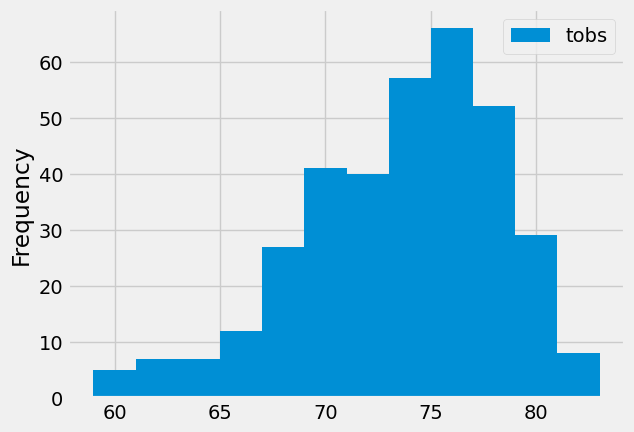

In [20]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tempdata = session.query(measure.tobs).filter(measure.date >=yearago).filter(measure.station == active[0][0]).all()
acttemp =[] #same as before, for loop is to make output into regular python list
for i in range(len(tempdata)):
    acttemp.append(tempdata[i][0])
# Save the query results as a Pandas DataFrame. Explicitly set the column names
temp_df=pd.DataFrame(data = {'tobs':acttemp}, columns = ['tobs'])

temp_df.plot(kind = "hist",bins = 12)

# Close Session

In [23]:
# Close Session
session.close()